<a href="https://colab.research.google.com/github/edgarsi/Remove-nights-from-a-timelapse-video/blob/main/Remove_nights_from_timelapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remove nights from a timelapse video

So you have a timelapse video of 200 days which flickers like a dank club party? Free GUI video editing software should be able to remove the nights, I couldn't find one... This notebook does it.


In [1]:
#@markdown ## Input file
INPUT_FILEPATH = "timelapse/video.mp4" #@param{type:"string"}

#@markdown ## Output file
OUTPUT_FILEPATH = "timelapse/video_daylight.mp4" #@param{type:"string"}

#@markdown ## Brightness threshold
THRESHOLD = 0.41 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown ## Remove sunrise/sunset.
#@markdown When sun sets or rises, the brightness may be quite high but the sun may be shining directly into the camera or creating unwanted glare when filming through a window. If you know the problem is some frames before or after a night, you can configure to cut them out.
REMOVE_FRAMES_BEFORE_NIGHT = 0 #@param {type:"number"}
REMOVE_FRAMES_AFTER_NIGHT = 0 #@param {type:"number"}

#@markdown ## Debug
#@markdown In debug mode, frames are marked with debug information instead - measured brightness, night/day, how many frames before or after a night is the current frame.
#@markdown The font size and text positions are reasonable for 720p images.
DEBUG = False #@param{type:"boolean"}
INCLUDE_NIGHTS = False #@param{type:"boolean"}

#@markdown ## Process just a part of the video
#@markdown Set this to something not a "-1" to process the first this many frames. Faster result, faster to see if the configuration works for a video.
LIMIT_FRAMES = -1 #@param {type:"number"}


In [2]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
print('Google Drive connected.')

Mounted at /content/gdrive
Google Drive connected.


In [3]:
# Install dependencies
!sudo apt-get install ffmpeg
!pip install opencv-python ipyplot


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [4]:
# !sudo apt-add-repository ppa:strukturag/libde265
# !sudo apt-add-repository ppa:videolan/stable-daily
# !sudo apt-get update && sudo apt-get upgrade
# !sudo apt-get install vlc gstreamer0.10-libde265 libde265 vlc-plugin-libde265

In [5]:
!# ffmpeg extract - Generating individual frame PNGs from the source file.
%rm -rf /content/images_in/
%shell mkdir /content/images_in

!ffmpeg -i '/content/gdrive/My Drive/{INPUT_FILEPATH}' '/content/images_in/%08d.png'


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [6]:
import cv2
from imageio import imread, imsave
import shutil
import ipyplot
import os
import sys
import itertools
from tqdm import tqdm
from functools import lru_cache
from PIL import ImageFont, ImageDraw, Image
from urllib.request import urlopen
import time
import numpy as np
from matplotlib import pyplot

tqdm.get_lock().locks = []  # sad tdqm&colab bug workaround


def debug(f):
    """ This decorator enables or disables debugging, such as and plastering 
    debug information on the output images. Helps to reason/tune algorithm 
    behaviour. """
    def wrapper(*pargs, **kwargs):
        if {DEBUG}:
            return f(*pargs, **kwargs)
    return wrapper


@lru_cache(maxsize=None)
def font():
    font_url = 'https://github.com/googlefonts/roboto/blob/master/src/hinted/Roboto-Bold.ttf?raw=true'
    font = ImageFont.truetype(urlopen(font_url), size=50)
    return font


@debug
def debug_text_on_image(image, s, position=0):
    canvas = np.full((image.shape), (0,0,0), dtype=np.uint8)
    canvas_pil = Image.fromarray(canvas)
    draw = ImageDraw.Draw(canvas_pil)
    coords = (15 + position, 15)
    draw.text(coords, s, font=font(), fill=(255,255,255,0))
    drawing = np.array(canvas_pil)
    x,y,w,h = cv2.boundingRect(drawing[:,:,2])
    m = 15  # black margin
    x,y,w,h = x-m,y-m,w+2*m,h+2*m
    image[y:y+h, x:x+w] = drawing[y:y+h, x:x+w]


def filenames(dir):
    def get(i):
        return os.path.join(dir, f'{i+1:0>8d}.png')
    return get


images_in = filenames('/content/images_in')
images_out = filenames('/content/images_out')


def images_out_next():
    filename = images_out(images_out_next.i)
    images_out_next.i += 1
    return filename
images_out_next.i = 0


@lru_cache(maxsize=None)
def total():
    cnt = len(os.listdir('/content/images_in'))
    cnt = len(range(cnt)[:LIMIT_FRAMES])
    return cnt


def frame_range():
    with tqdm(total=total(), file=sys.stdout, smoothing=0, position=0) as pbar:
        for i in range(total()):
            pbar.update(1)
            yield i


def frame(i):
    return imread(images_in(i))


def frame_brightness(frame):
    return frame.sum() / (255 * frame.size)


@lru_cache(maxsize=None)
def brightnesses():
    return [frame_brightness(frame(i)) for i in frame_range()]




print('Measuring frame brightness')
_ = brightnesses()





        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        
Measuring frame brightness
100%|██████████| 9159/9159 [08:49<00:00, 17.31it/s]


In [7]:
# Filter out nights
%rm -rf /content/images_out
%mkdir /content/images_out

def brightness(i):
    return brightnesses()[i]


def is_day_brightness(brightness):
    return brightness > THRESHOLD


def is_day(i):
    return is_day_brightness(brightness(i))


@lru_cache(maxsize=None)
def frame_night_distance():
    frames_to_night = []
    frames_from_night = []
    for day, g in itertools.groupby(brightnesses(), is_day_brightness):
        frames = list(g)
        for i, _ in enumerate(frames):
            frames_to_night.append(len(frames) - i if day else 0)
            frames_from_night.append(i + 1 if day else 0)
    return {'to_night': frames_to_night, 'from_night': frames_from_night}


def frames_from_night(i):
    return frame_night_distance()['from_night'][i]


def frames_to_night(i):
    return frame_night_distance()['to_night'][i]


def is_wanted_daylight_image(i):
    return is_day(i) \
        and frames_from_night(i) >= REMOVE_FRAMES_AFTER_NIGHT \
        and frames_to_night(i) >= REMOVE_FRAMES_BEFORE_NIGHT


def create_debug_images():
    for i in frame_range():
        if INCLUDE_NIGHTS or is_wanted_daylight_image(i):
            f = frame(i)
            debug_text_on_image(f, f'Brightness: {brightness(i):.2f}', 0)
            debug_text_on_image(f, ('Day' if is_day(i) else 'Night'), 700)
            ffn = frames_from_night(i)
            ftn = frames_to_night(i)
            debug_text_on_image(f, f'Frames from/to night: {ffn} / {ftn}', 1000)
            imsave(images_out_next(), f)
            # pyplot.figure(dpi=500)
            # pyplot.imshow(f)
            # pyplot.show()
            # sys.exit(0)


def create_images():
    assert not INCLUDE_NIGHTS
    for i in frame_range():
        if is_wanted_daylight_image(i):
            shutil.copy(images_in(i), images_out_next())

if DEBUG:
    print('Creating debug images')
    create_debug_images()
else:
    print('Copying daylight images')
    create_images()

print(f'{images_out_next.i} ({100*images_out_next.i/total():.0f}%) '
    'of the frames were bright enough')
print('Done')


Creating debug images
100%|██████████| 9159/9159 [1:03:29<00:00,  2.40it/s]
1715 (19%) of the frames were bright enough
Done


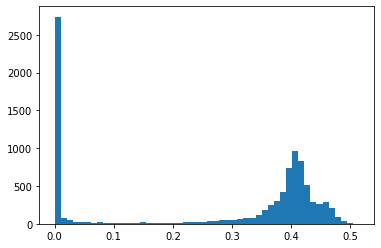

In [8]:
from matplotlib import pyplot

pyplot.hist(brightnesses(), bins=50)
pyplot.show()


In [9]:

fps, = !ffprobe -v 0 -of csv=p=0 -select_streams v:0 -show_entries stream=r_frame_rate '/content/gdrive/My Drive/{INPUT_FILEPATH}'
fps, = !bash -c 'echo $(({fps}))'
!echo '{fps}'

%shell ffmpeg -y -r {fps} -f image2 -pattern_type glob -i '/content/images_out/*.png' '/content/gdrive/My Drive/{OUTPUT_FILEPATH}'

59
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-